In [1]:
from dateutil.relativedelta import *
from dateutil.easter import *
from dateutil.rrule import *
from dateutil.parser import *
from datetime import *
from sklearn.preprocessing import LabelEncoder

import conf
from UI.LOG import *
import cv2
from aml.train_pipeline import *  
from aml.train_pipeline import *
import pandas as pd

import os
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor,FasterRCNN_ResNet50_FPN_Weights
from torchinfo import summary

# from torchvision.models.detection import ssd300_vgg16,SSD300_VGG16_Weights
from torchvision.models.detection.ssd import SSDClassificationHead,SSD300_VGG16_Weights,det_utils
from torchvision.models.detection import ssd300_vgg16

import torch

import aml.model_using as model_using
import aml.support_func as support_funcS
import aml.time_mesuarment as time_mesuarment
import sys

import aml.managers as managers
import aml.img_processing as img_processing
import random
import numpy as np
import pprint
from torchinfo import summary
from aml.img_processing import *

from PIL import Image
import aml.models as models
import matplotlib.pyplot as plt
from pprint import pprint as Print
from PIL import Image
import warnings
from torchvision.utils import draw_bounding_boxes  
from torchvision.io.image import read_image
from torchvision.transforms.functional import to_pil_image
from torchvision.ops import nms 
from torchmetrics.detection.mean_ap import MeanAveragePrecision as mAP
from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
from IPython.display import IFrame, display, HTML
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from data_manip import cat_features_
import catboost
from io import StringIO 
import sys
from sklearn.metrics import roc_auc_score
from catboost import utils
from sklearn import metrics
from numba import jit

In [2]:
X = pd.read_csv(conf.X_train_dataset,index_col=False)
Y = pd.read_csv(conf.train_target,index_col=False).drop(columns=['index'])

In [3]:
X_train, X_validation, y_train, y_validation = train_test_split(X, Y, train_size=0.8, random_state=1234)
features_names = [el for el in X]
cat_features = np.setdiff1d(cat_features_,np.setdiff1d(cat_features_,features_names))

In [4]:
model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    random_seed=0,
    loss_function='Logloss',
    task_type='GPU',
    early_stopping_rounds=20,
    custom_loss='AUC',
)


In [5]:
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=True
    )

Default metric period is 5 because AUC is/are not implemented for GPU


0:	learn: 0.6408848	test: 0.6408408	best: 0.6408408 (0)	total: 72.8ms	remaining: 7.21s
1:	total: 143ms	remaining: 7.02s
2:	total: 208ms	remaining: 6.72s
3:	total: 274ms	remaining: 6.58s
4:	total: 342ms	remaining: 6.5s
5:	learn: 0.5104079	test: 0.5101547	best: 0.5101547 (5)	total: 411ms	remaining: 6.43s
6:	total: 473ms	remaining: 6.29s
7:	total: 538ms	remaining: 6.19s
8:	total: 601ms	remaining: 6.08s
9:	total: 663ms	remaining: 5.97s
10:	learn: 0.4697285	test: 0.4693386	best: 0.4693386 (10)	total: 731ms	remaining: 5.92s
11:	total: 795ms	remaining: 5.83s
12:	total: 860ms	remaining: 5.76s
13:	total: 926ms	remaining: 5.69s
14:	total: 990ms	remaining: 5.61s
15:	learn: 0.4556917	test: 0.4551850	best: 0.4551850 (15)	total: 1.06s	remaining: 5.54s
16:	total: 1.12s	remaining: 5.45s
17:	total: 1.17s	remaining: 5.35s
18:	total: 1.24s	remaining: 5.29s
19:	total: 1.3s	remaining: 5.2s
20:	learn: 0.4499312	test: 0.4493353	best: 0.4493353 (20)	total: 1.37s	remaining: 5.14s
21:	total: 1.43s	remaining: 5.

In [6]:
def load_catboost_train_info(train_folder):
    learn_error = pd.read_table(os.path.join(train_folder,'learn_error.tsv'))
    test_error =pd.read_table(os.path.join(train_folder,'test_error.tsv'))
    return learn_error,test_error
def plot_catboost_train_info(train_folder='./catboost_info'):
    l_err,t_errs = load_catboost_train_info(train_folder=train_folder)
    fig, ax = plt.subplots()
    fig.set_size_inches(16,9)
    l_err_name = [el for el in l_err][1]
    test_errors_names = [el for el in t_errs][1:]
    ax.plot(l_err[l_err_name],label='train '+l_err_name)
    for i,err_name in enumerate(test_errors_names):
        ax.plot(t_errs[err_name],label='val '+ err_name)

    ax.legend()
    return fig,ax
def simple_plot(x,y,title=''):
    fig, ax = plt.subplots()
    fig.set_size_inches(16,9)
    ax.plot(x,y)
    ax.set_title(title)
    return fig,ax
def Gini(fpr,tpr):
    return 2*metrics.auc(fpr,tpr)-1



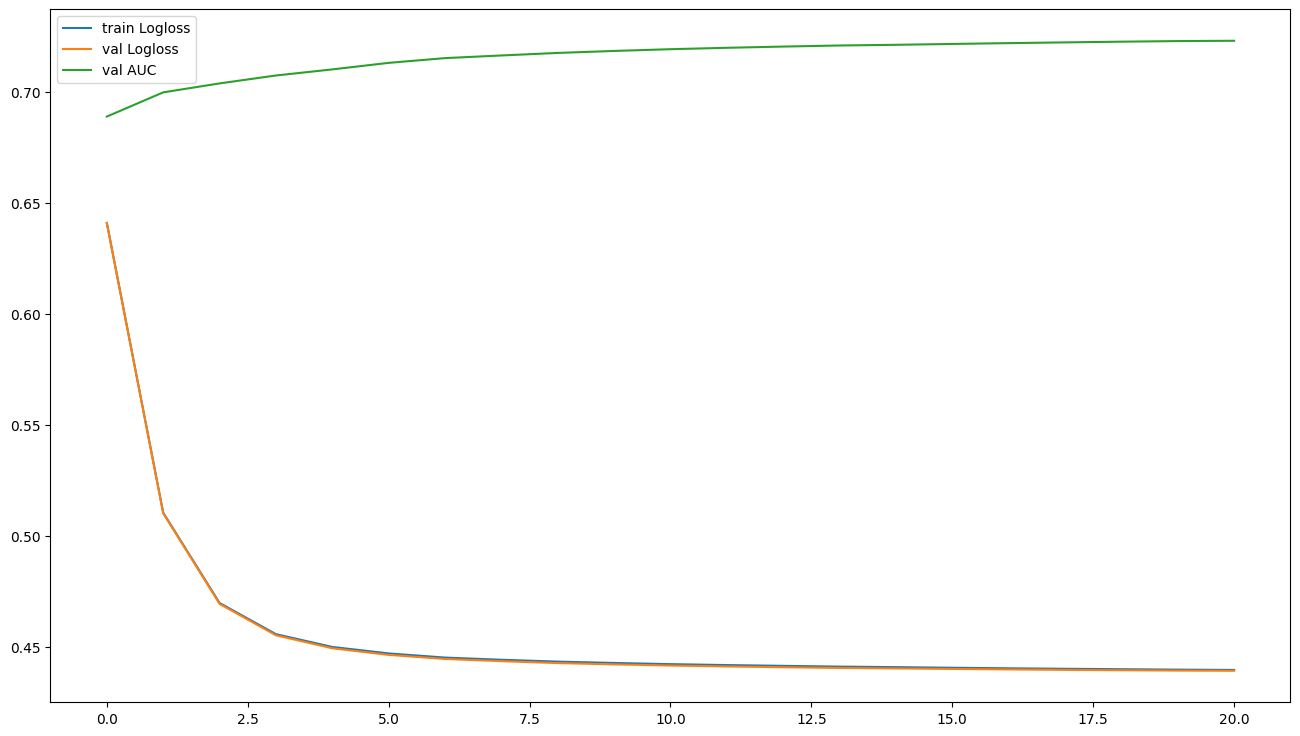

In [7]:
fig,ax = plot_catboost_train_info(train_folder='./catboost_info/')

In [8]:
pred_ = model.predict(X_train)
probs_ = model.predict_proba(X_train)

In [9]:
p_ = catboost.Pool(
    data=X_train,
    cat_features=cat_features,
    label=y_train.values
)
(fpr, tpr, thresholds) = utils.get_roc_curve(model,p_)

(<Figure size 1600x900 with 1 Axes>, <Axes: title={'center': 'ROC'}>)

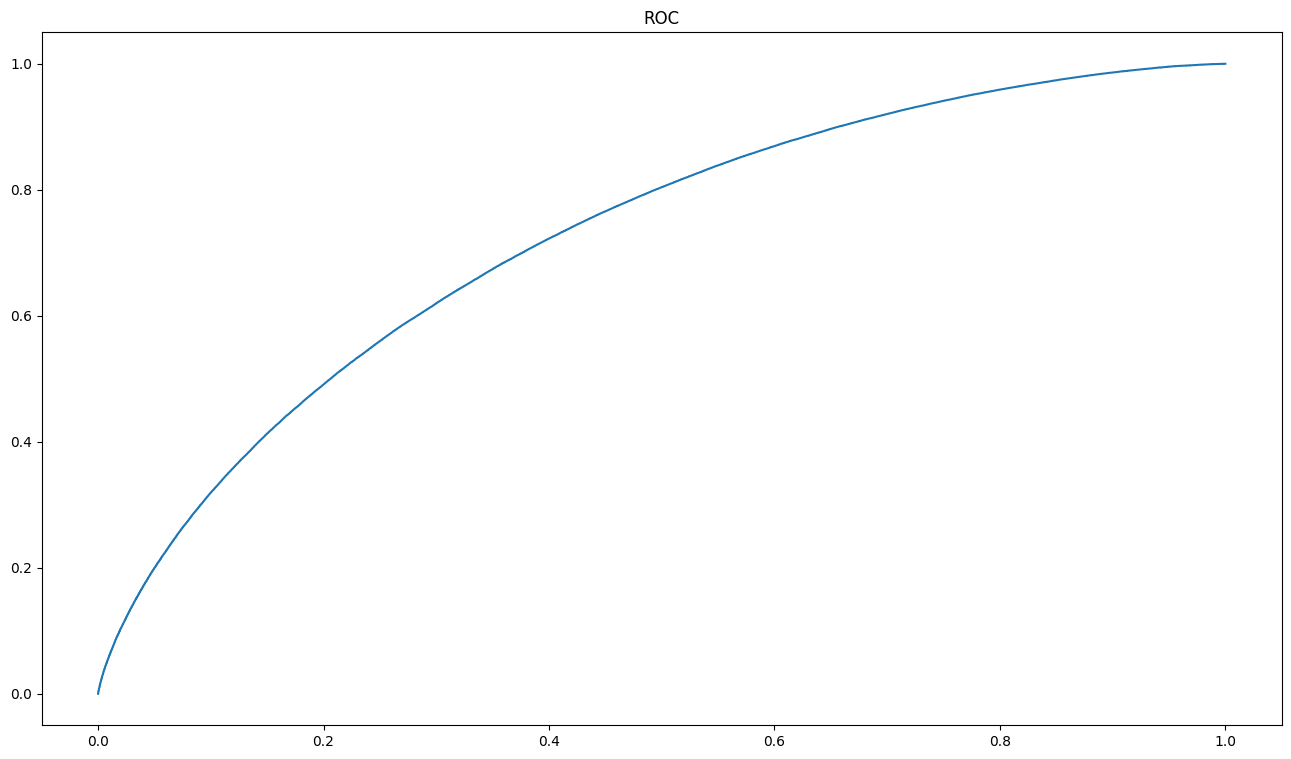

In [38]:
simple_plot(fpr,tpr,title='ROC')

In [43]:
print(Gini(fpr,tpr))
print(metrics.auc(fpr,tpr))
scores_ = probs_[:,1]
print(scores_)
fpr1,tpr1,tr1 = metrics.roc_curve(y_train,scores_,pos_label=1)
print(fpr1)
print(tpr1)

0.447610934349852
0.723805467174926
[0.19140662 0.13456581 0.11895406 ... 0.32567809 0.07400401 0.12699746]
[0.         0.         0.         ... 0.99980504 0.99980504 1.        ]
[0.00000000e+00 5.39412149e-06 1.13276551e-04 ... 9.99994606e-01
 1.00000000e+00 1.00000000e+00]


0.7238054671749259


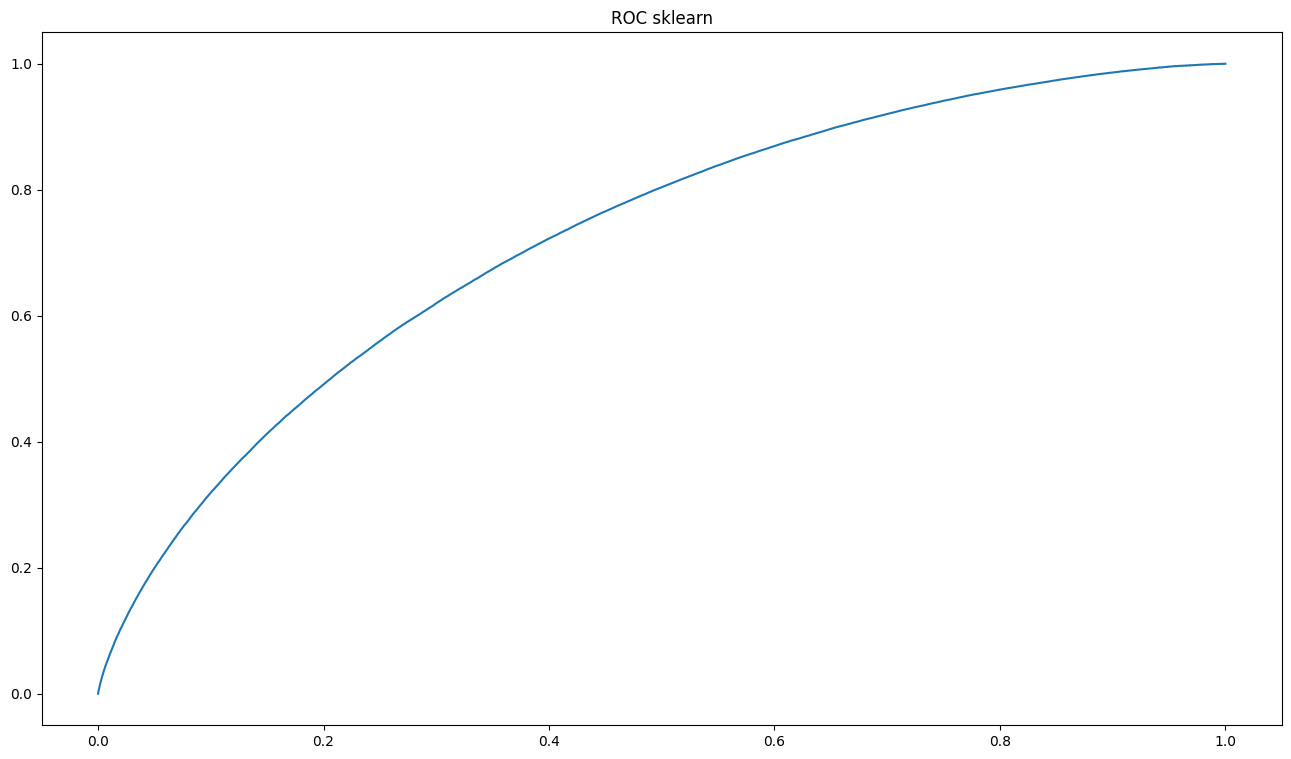

In [44]:
simple_plot(fpr1,tpr1,title='ROC sklearn')
print(metrics.auc(fpr1,tpr1))

In [46]:
import xgboost as xgb
from xgboost import XGBClassifier

In [47]:
dtrain_ = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dval_ = xgb.DMatrix(X_validation, y_validation, enable_categorical=True)

In [48]:
model2 = XGBClassifier(objective="binary:logistic",tree_method='gpu_hist',gpu_id=0,eval_metric='auc',seed=0)


In [49]:
model2.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_validation, y_validation)],verbose=True)

[0]	validation_0-auc:0.69866	validation_1-auc:0.69761
[1]	validation_0-auc:0.70388	validation_1-auc:0.70281
[2]	validation_0-auc:0.70583	validation_1-auc:0.70444
[3]	validation_0-auc:0.70771	validation_1-auc:0.70615
[4]	validation_0-auc:0.70973	validation_1-auc:0.70830
[5]	validation_0-auc:0.71119	validation_1-auc:0.70927
[6]	validation_0-auc:0.71315	validation_1-auc:0.71122
[7]	validation_0-auc:0.71445	validation_1-auc:0.71214
[8]	validation_0-auc:0.71575	validation_1-auc:0.71341
[9]	validation_0-auc:0.71699	validation_1-auc:0.71444
[10]	validation_0-auc:0.71834	validation_1-auc:0.71568
[11]	validation_0-auc:0.71986	validation_1-auc:0.71675
[12]	validation_0-auc:0.72083	validation_1-auc:0.71753
[13]	validation_0-auc:0.72201	validation_1-auc:0.71842
[14]	validation_0-auc:0.72313	validation_1-auc:0.71924
[15]	validation_0-auc:0.72378	validation_1-auc:0.71975
[16]	validation_0-auc:0.72452	validation_1-auc:0.72017
[17]	validation_0-auc:0.72521	validation_1-auc:0.72071
[18]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

(<Figure size 1600x900 with 1 Axes>, <Axes: >)

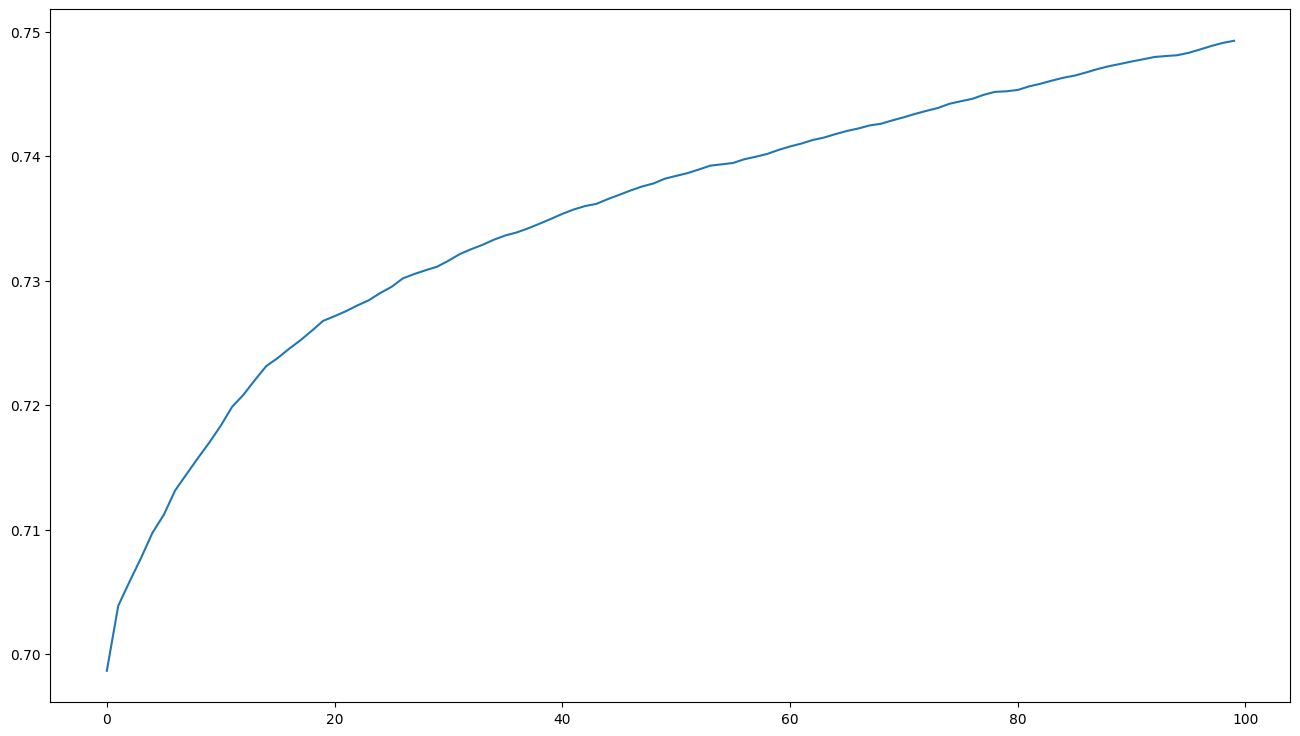

In [50]:
results = model2.evals_result()
auc_vec = results['validation_0']['auc']
simple_plot(np.arange(0,len(auc_vec)), auc_vec)

In [51]:
preds_2 = model2.predict(X_train)
proba2 = model2.predict_proba(X_train)


0.7492623274489565
0.498524654897913


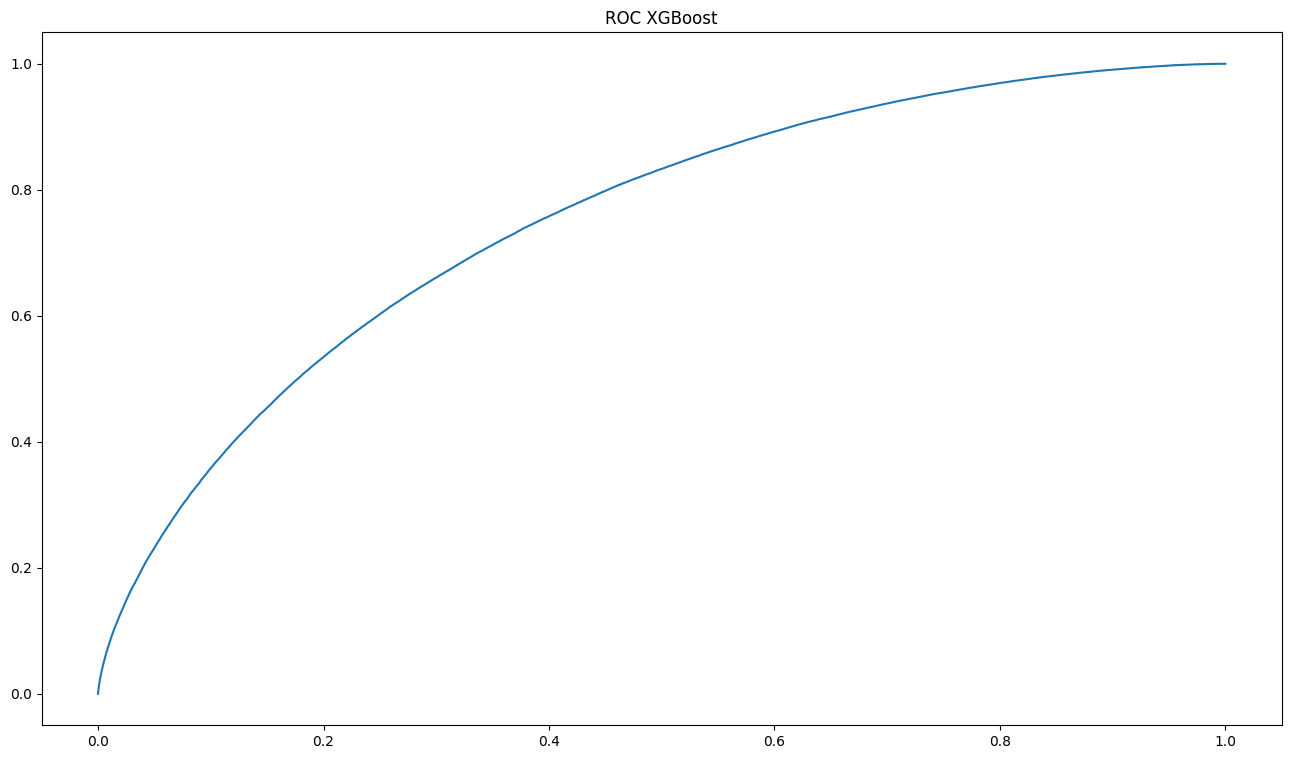

: 

In [53]:
fpr2,tpr2,tr2 = metrics.roc_curve(y_train,proba2[:,1],pos_label=1)
simple_plot(fpr2,tpr2,title='ROC XGBoost')
print(metrics.auc(fpr2,tpr2))
print(Gini(fpr2,tpr2))